# learning-AI101 : raisin classification (DL)
### 건포도 데이터를 Dense layer struction을 통한 DNN 방식 및 CNN을 적용하여 classification 

<br>

- **임규연 (lky473736)**
- 2024.07.30. ~ 2024.08.01.에 DL 작성
- **dataset** : https://archive.ics.uci.edu/dataset/850/raisin
- **data abstract** : Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.

------

- **CAUTION** : 데이터 EDA는 raisin classification (ML)에서 진행하여, 본 문서에서는 진행하지 않습니다.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [32]:
# 데이터 불러오기

df = pd.read_excel('./data/Raisin_Dataset/Raisin_Dataset.xlsx')
df.info()
print (df.columns)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB
Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter', 'Class'],
      dtype='object')


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


-----

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 raisin을 classification한다. 목차는 아래와 같다.

- **1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용**
- **2. ANN (fully connected)**
- **3. DNN**
- **4. CNN**

-------

### 1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현 후 classification score를 확인해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : log_loss (logistic regression (sigmoid))
- max_iter : 10~30 (randint)

In [33]:
# data split 및 normalization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

raisin_input = df[df.columns[:-1]]
raisin_target = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(raisin_input, raisin_target, 
                                                   stratify=raisin_target, test_size=0.2)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [34]:
# random search를 통한 hyperparameter tuning

from sklearn.linear_model import SGDClassifier
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param = {
    'max_iter' : randint(10, 30)
}

sc = SGDClassifier(loss='log_loss')
rs = RandomizedSearchCV(sc, param, n_iter=20, n_jobs=-1)
rs.fit (X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss'), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14fa065d0>})

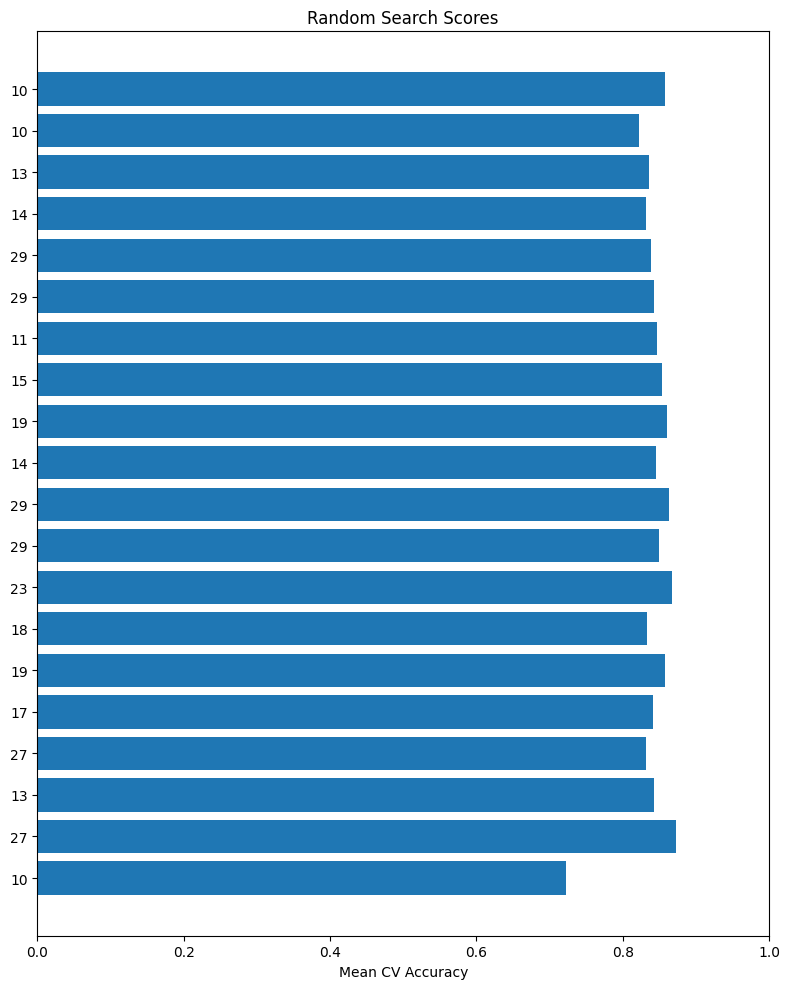

In [35]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(8, 10))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"{compo}" for compo in max_iter_values])
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim((0, 1))
plt.tight_layout()
plt.show()

In [36]:
# best score, best model, train score, test score

sc = rs.best_estimator_
print ("best score : ", rs.best_score_)
print ("best estimator (model) : ", sc)

sc_score = [sc.score(X_train_scaled, y_train), sc.score(X_test_scaled, y_test)]
print (f"train score, test score : {sc_score}")

best score :  0.8722222222222221
best estimator (model) :  SGDClassifier(loss='log_loss', max_iter=27)
train score, test score : [0.8666666666666667, 0.8444444444444444]


현재 본 dataset의 feature은 7개이므로, 아래와 같은 linear combination formula를 작성할 수 있다.

$z = w_1 \times f_1 + w_2 \times f_2 +  w_3 \times f_3 +  w_4 \times f_4 +  w_5 \times f_5 +  w_6 \times f_6 +  w_7 \times f_7 + bias$

**결과적으로 7개의 model paramter가 loss function의 global minima에 도달할 때까지 learning rate에 의해 조절되어 가면서, 최적의 weight와 bias를 찾게 되는 것**이다. 이를 조금 더 자세히 구현하고 layer 각각을 디자인하기 위해 Dense를 struction한다. 

-------

### 2. ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 우선, 기존 train set에서 validation set을 하나 더 구성하여 추후 evaluation에 사용할 예정이다.
- 또한 one-hot encoding하여 target값을 0과 1로 구성하고 loss function은 categorical_crossentropy를 사용한다.
    - one-hot encoding하는 방식 중 scikit-learn 내장 메소드인 OneHotEncoder를 사용한다.

#### 2-1) validation set 구성 및 one-hot encoding

In [37]:
# train set에서 validation set을 하나 더 구성

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train,
                                                               test_size=0.2, 
                                                               stratify=y_train)

print (X_train_scaled.shape, X_val_scaled.shape)

(576, 7) (144, 7)


In [38]:
# one-hot encoding

from sklearn.preprocessing import OneHotEncoder

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

# kecimen, Besni 이렇게 두 target이니, 제대로 one-hot encoding된 것을 확인 가능

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### 2-2) modelling, compile, fit

records shape :  (8,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 7)                 0         
                                                                 
 dense_6 (Dense)             (None, 2)                 16        
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


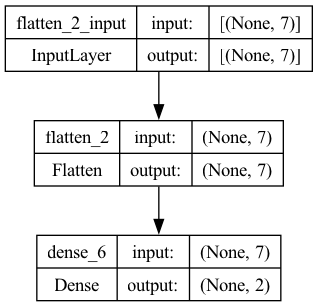

In [39]:
# modelling

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [40]:
# compile

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [41]:
# fit

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, 
                   validation_data=(X_val_scaled, y_val))

print (history.history)

Epoch 1/50
29/29 [==============================] - 0s 6ms/step - loss: 0.7516 - accuracy: 0.5833 - val_loss: 0.7092 - val_accuracy: 0.6319
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7072 - accuracy: 0.6285 - val_loss: 0.6775 - val_accuracy: 0.6458
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6688 - accuracy: 0.6701 - val_loss: 0.6480 - val_accuracy: 0.6944
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6327 - accuracy: 0.7309 - val_loss: 0.6225 - val_accuracy: 0.7153
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.7587 - val_loss: 0.5994 - val_accuracy: 0.7431
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5729 - accuracy: 0.7812 - val_loss: 0.5787 - val_accuracy: 0.7569
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.5479 - accuracy: 0.7934 - val_loss: 0.5601 - val_accuracy: 0.7639
Epoch 8/50
29/29 [==

#### 2-3) loss 시각화 및 evaluate

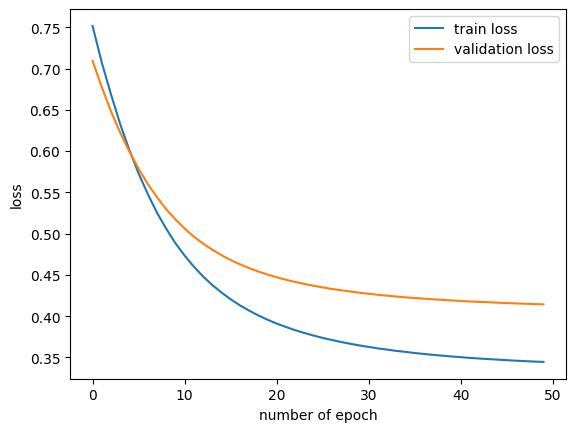

In [42]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

위 그래프를 통해 알 수 있는 사실은 아래와 같다.

- **loss 감소 패턴의 동일성**
  - train loss과 validation loss 모두 에포크가 진행됨에 따라 감소하고 있음
  - loss가 줄어든다 -> accuracy가 상승한다.

- **overfitting 여부**
  - 두 손실 곡선이 비슷한 형태로 감소하고 있고, 검증 손실이 훈련 손실보다 크게 차이나지 않기 때문에, overfitting이 심하게 난다고 볼 수 없음
  - 만약 에포크가 더 진행되면 overfitting 발생할 가능성도 있음

- **모델 복잡도**
  - **ANN 모델의 파라미터가 16개밖에 되지 않기 때문에 매우 간단**한 모델
  - 간단한 모델이기 때문에, 학습이 잘 이루어지고 validation data set에 대한 일반화 성능도 준수한 것


In [43]:
# evaluate

model.evaluate(X_val_scaled, y_val)

5/5 [==============================] - 0s 2ms/step - loss: 0.4143 - accuracy: 0.8681


[0.41432255506515503, 0.8680555820465088]

-------

### 3. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 15000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 30으로 고정
- 아래와 같이 experiment할 예정이다.
    - **(1) hidden layer을 추가하여 DNN 구성**
        - (1) 기본 경사 하강법
            - (1-1-1) optimizer : SGD
            - (1-1-2) optimizer : momentum optimization
            - (1-1-3) optimizer : nesterov momentum optimization
            - (1-1-4) 시각화 및 비교
        - (2) 적응적 학습율
            - (1-2-1) optimizer : RMSprop (기본값)
            - (1-2-2) optimizer : Adagrad
            - (1-2-3) optimizer : Adam
            - (1-2-4) 시각화 및 비교
    - **(2) validation loss 감소를 위한 시도**
        - (1) dropout
        - (2) callback : early stopping

#### 3-1) hidden layer를 추가하여 DNN 구성

records shape :  (8,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 7)                 0         
                                                                 
 dense_7 (Dense)             (None, 256)               2048      
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 2)                 34        
                                                                 
Total params: 21138 (82.57 KB)
T

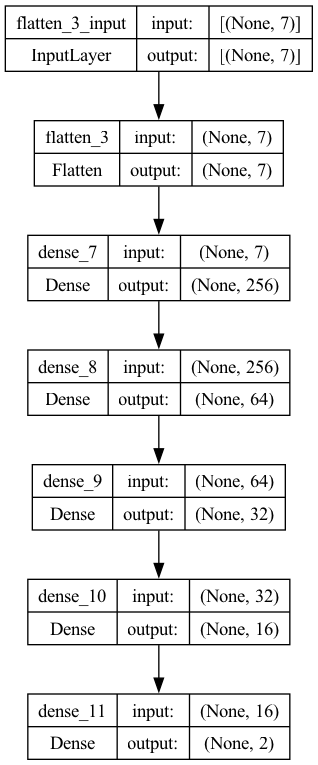

In [44]:
# modelling DNN

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

##### 3-1-1) 기본 경사 하강법
##### (1-1-1) optimizer : SGD

In [45]:
# compile, fit

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.6740 - accuracy: 0.5035 - val_loss: 0.6628 - val_accuracy: 0.5556
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6432 - accuracy: 0.6528 - val_loss: 0.6361 - val_accuracy: 0.6806
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 0.8090 - val_loss: 0.6088 - val_accuracy: 0.7847
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5790 - accuracy: 0.8368 - val_loss: 0.5796 - val_accuracy: 0.8056
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5479 - accuracy: 0.8507 - val_loss: 0.5536 - val_accuracy: 0.8264
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.8646 - val_loss: 0.5297 - val_accuracy: 0.8264
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.4955 - accuracy: 0.8681 - val_loss: 0.5085 - val_accuracy: 0.8264
Epoch 8/30
32/32 [==

In [46]:
# evaluate

sgd_score = model.evaluate(X_val_scaled, y_val)
print (sgd_score)##### (1-1-2) optimizer : momentum optimization

5/5 [==============================] - 0s 2ms/step - loss: 0.3741 - accuracy: 0.8611
[0.3740997612476349, 0.8611111044883728]


##### (1-1-2) optimizer : momentum optimization

In [47]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.3228 - accuracy: 0.8715 - val_loss: 0.3762 - val_accuracy: 0.8819
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3209 - accuracy: 0.8750 - val_loss: 0.3786 - val_accuracy: 0.8403
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3177 - accuracy: 0.8733 - val_loss: 0.3795 - val_accuracy: 0.8403
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.8802 - val_loss: 0.3786 - val_accuracy: 0.8819
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3150 - accuracy: 0.8698 - val_loss: 0.3742 - val_accuracy: 0.8472
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.8802 - val_loss: 0.3742 - val_accuracy: 0.8472
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.8750 - val_loss: 0.3754 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [48]:
# evaluate

momentum_score = model.evaluate(X_val_scaled, y_val)
print (momentum_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8611
[0.3731541633605957, 0.8611111044883728]


##### (1-1-3) optimizer : nesterov momentum optimization

In [49]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2853 - accuracy: 0.8889 - val_loss: 0.3792 - val_accuracy: 0.8681
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2897 - accuracy: 0.8802 - val_loss: 0.3729 - val_accuracy: 0.8611
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.8837 - val_loss: 0.3723 - val_accuracy: 0.8750
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2820 - accuracy: 0.8854 - val_loss: 0.3671 - val_accuracy: 0.8542
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2856 - accuracy: 0.8819 - val_loss: 0.3758 - val_accuracy: 0.8403
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.8819 - val_loss: 0.3739 - val_accuracy: 0.8750
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2822 - accuracy: 0.8854 - val_loss: 0.3639 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [50]:
# evaluate

nesterov_score = model.evaluate(X_val_scaled, y_val)
print (nesterov_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3688 - accuracy: 0.8611
[0.36880138516426086, 0.8611111044883728]


##### (1-1-4) 시각화 및 비교

[0.3740997612476349, 0.3731541633605957, 0.36880138516426086, 0.8611111044883728, 0.8611111044883728, 0.8611111044883728]


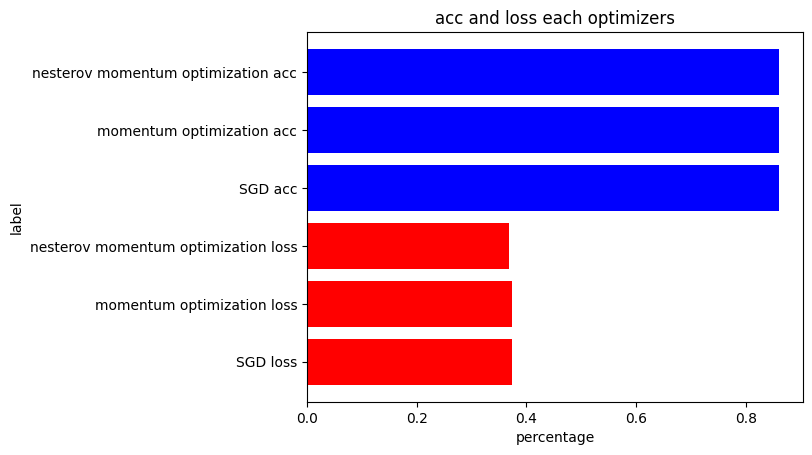

In [51]:
labels = [
    'SGD loss',
    'momentum optimization loss',
    'nesterov momentum optimization loss',
    'SGD acc',
    'momentum optimization acc',
    'nesterov momentum optimization acc',
]

scores = [compo[0] for compo in [sgd_score, momentum_score, nesterov_score]] + [compo[1] for compo in [sgd_score, momentum_score, nesterov_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

##### 3-1-2) 적응적 학습율
- 전에 보았던 learning rate는 전부 기본값 0.01로 고정된 채 SGD를 내부적으로 진행한 것
- 모델이 global minima에 가까이 갈 수록 learning rate를 낮추는 optimizer를 사용하면 전보다 더 나은 성능을 보일 수 있을 것이라고 생각한다
<br>

##### (1-2-1) optimizer : RMSprop

In [52]:
# compile, fit

rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2776 - accuracy: 0.8872 - val_loss: 0.3927 - val_accuracy: 0.8403
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2616 - accuracy: 0.8906 - val_loss: 0.3922 - val_accuracy: 0.8542
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2753 - accuracy: 0.8941 - val_loss: 0.3656 - val_accuracy: 0.8681
Epoch 4/30
32/32 [==============================] - 0s 3ms/step - loss: 0.2602 - accuracy: 0.9045 - val_loss: 0.4000 - val_accuracy: 0.8403
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.8993 - val_loss: 0.3880 - val_accuracy: 0.8611
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2605 - accuracy: 0.8906 - val_loss: 0.3864 - val_accuracy: 0.8194
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2585 - accuracy: 0.8993 - val_loss: 0.3777 - val_accuracy: 0.8403
Epoch 8/30
32/32 [==

In [53]:
# evaluate

rmsprop_score = model.evaluate(X_val_scaled, y_val)
print (rmsprop_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.3920 - accuracy: 0.8264
[0.392044335603714, 0.8263888955116272]


##### (1-2-2) optimizer : Adagrad

In [54]:
# compile, fit

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history) 

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2255 - accuracy: 0.9045 - val_loss: 0.3866 - val_accuracy: 0.8264
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2161 - accuracy: 0.9097 - val_loss: 0.3845 - val_accuracy: 0.8264
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9115 - val_loss: 0.3841 - val_accuracy: 0.8333
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9149 - val_loss: 0.3837 - val_accuracy: 0.8333
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.9167 - val_loss: 0.3840 - val_accuracy: 0.8333
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9201 - val_loss: 0.3842 - val_accuracy: 0.8333
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2049 - accuracy: 0.9219 - val_loss: 0.3846 - val_accuracy: 0.8333
Epoch 8/30
32/32 [==

In [55]:
# evaluate

adagrad_score = model.evaluate(X_val_scaled, y_val)
print (adagrad_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.3918 - accuracy: 0.8264
[0.39178240299224854, 0.8263888955116272]


##### (1-2-3) optimizer : Adam

In [56]:
# compile, fit

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history) 

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2467 - accuracy: 0.9045 - val_loss: 0.3999 - val_accuracy: 0.8333
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2338 - accuracy: 0.9045 - val_loss: 0.4021 - val_accuracy: 0.8125
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9062 - val_loss: 0.4148 - val_accuracy: 0.8333
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2204 - accuracy: 0.9115 - val_loss: 0.4462 - val_accuracy: 0.8264
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2287 - accuracy: 0.9080 - val_loss: 0.4340 - val_accuracy: 0.8194
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2352 - accuracy: 0.9115 - val_loss: 0.4174 - val_accuracy: 0.8194
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.9097 - val_loss: 0.3953 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [57]:
# evaluate

adam_score = model.evaluate(X_val_scaled, y_val)
print (adam_score )

5/5 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.8264
[0.44946539402008057, 0.8263888955116272]


##### (2-1-4) 시각화 및 비교

[0.392044335603714, 0.39178240299224854, 0.44946539402008057, 0.8263888955116272, 0.8263888955116272, 0.8263888955116272]


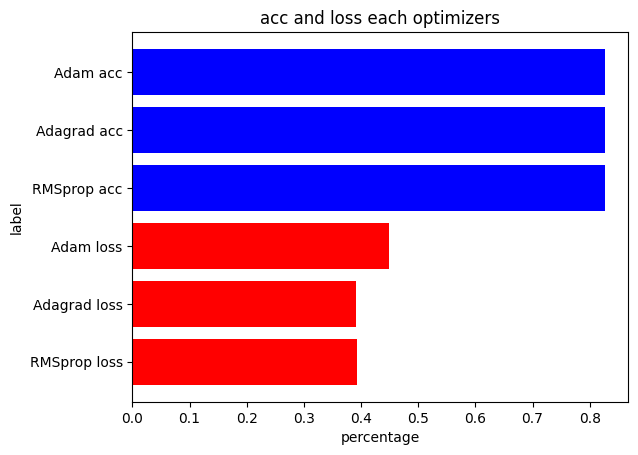

In [58]:
# visualization

labels = [
    'RMSprop loss',
    'Adagrad loss',
    'Adam loss',
    'RMSprop acc',
    'Adagrad acc',
    'Adam acc',
]

scores = [compo[0] for compo in [rmsprop_score, adagrad_score, adam_score]] + [compo[1] for compo in [rmsprop_score, adagrad_score, adam_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

위 figure을 보고 다음과 같은 사실을 유추 가능하다.
- **Adagrad의 acc가 가장 높으며, loss도 가장 낮다**
- Adam의 loss가 가장 높으며, Adagrad의 loss가 가장 낮다. 

동일선상에서 비교하였을 때, 현재 dataset에서의 optimizer는 **adagrad가 적합**하다고 볼 수 있다. 따라서 추후 validation loss 감소를 위한 시도 때에서의 model optimizer는 adagrad를 사용할 것이다.

#### 3-2) validation loss 감소를 위한 시도

```sh
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 flatten_6 (Flatten)         (None, 7)                 0         
                                                                 
 dense_10 (Dense)            (None, 256)               2048      
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
=================================================================
```
- validation loss 감소를 위하여 아래와 같은 방법을 시도해 볼 것이다.
    - **dropout** 
        - 위 figure를 보았을 때, dense_11에서 param이 가장 많이 밀집된 것을 확인 가능하다. 따라서 여기서 30%의 dropout을 하여 특정 노드의 의존성을 해제하겠다.
    - **early stopping**
        - 5번 연속 검증 점수가 향상되지 않을 시 훈련을 중지할 것이다.

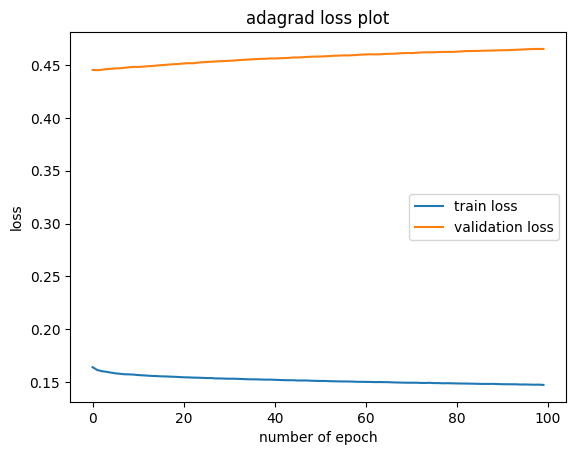

In [59]:
# optimizer인 adagrad를 이용한 compile, fit 및 loss 시각화
# 여기에선 epoch를 100으로 늘려 fit한다.

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**일단 되게 난감한 상황인게, validation loss가 epoch가 늘어남에 따라서 계속적으로 우상향하고 있다.** 이는 즉 학습을 거듭할 수록 overfitting되어가고 있다는 의미인데, 이를 해결하기 위하여 dropout해보자.

##### 3-2-1) dropout

records shape :  (8,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 7)                 0         
                                                                 
 dense_12 (Dense)            (None, 256)               2048      
                                                                 
 dense_13 (Dense)            (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (No

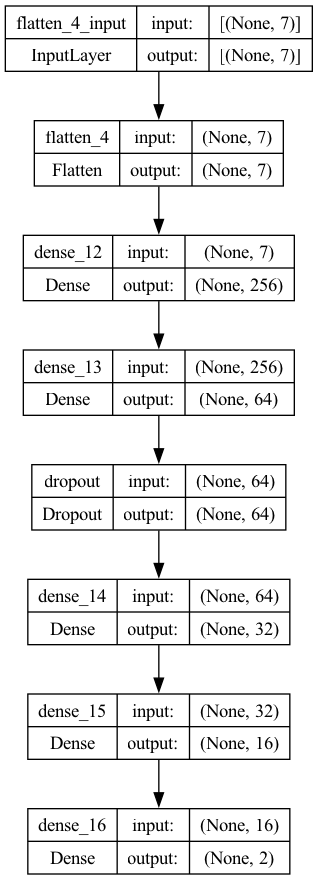

In [60]:
# modelling DNN + dropout

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),  # dropout 층 추가
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

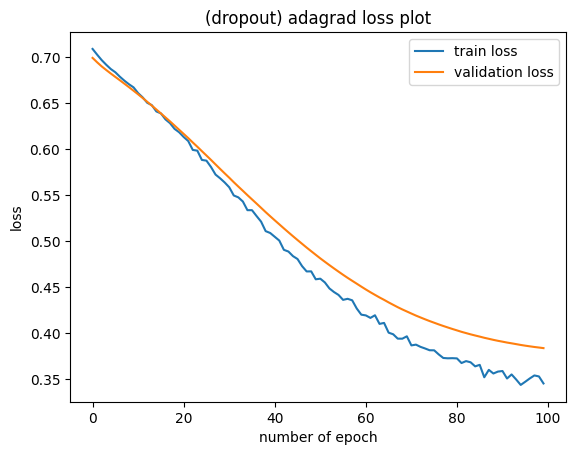

In [61]:
# 재학습 및 재시각화

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('(dropout) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**overfitting을 막았다.** validation loss는 완벽한 우하향 곡선을 띄고 있는데, 계속적으로 감소하고 있으며 음의 무한대로 발산하고 있다.

##### 3-2-2) early stopping

In [62]:
# ModelCheckpoint와 EarlyStopping 메소드를 차례대로 사용하여 구현

model.compile(loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/classification_raisin_model_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                   callbacks=[checkpoint_cb, early_stopping_cb], verbose=0)

print ("best epochs : ", early_stopping_cb.stopped_epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epochs :  7


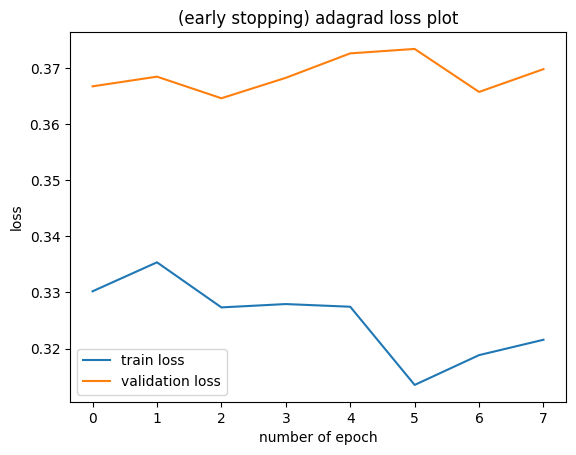

In [63]:
# 시각화

plt.title('(early stopping) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

-------

### 4. CNN 
- convolution을 이용하여 유용한 feature을 드러내게 한 후, 그에 따른 유의미한 학습을 진행한다. 
- 아래와 같이 진행한다.
    - (1) split_sequences에 대한 완전한 이해
    - (2) sequence 변환 및 데이터 분리 
    - (3) modelling
    - (4) compile, fit
    - (5) evaluate